In [1]:
from skimage.io import imread
import os
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from skimage.color import gray2rgb, rgb2gray

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

from torchviz import make_dot
from joblib import Parallel, delayed, parallel_backend


In [2]:

def load_nuclei_data(data_path):
    images = []
    masks = []
    root = data_path
    for subdir in tqdm(os.listdir(root)):
        subfolder = os.path.join(root,subdir)
        if os.path.isdir(subfolder):
#             print(subdir)
            for subsubfolder_name in os.listdir(subfolder):
                if subsubfolder_name == 'images':
                    for _,_,files in os.walk(os.path.join(subfolder,subsubfolder_name)):
                        for file in files:
                            if file.endswith('.png'):
                                images.append(imread(os.path.join(subfolder,subsubfolder_name,file)))
                if subsubfolder_name == 'masks':
                    for _,_,files in os.walk(os.path.join(subfolder,subsubfolder_name)):
                        mask = []
                        for file in files:
                            if file.endswith('.png'):
                                mask.append(imread(os.path.join(subfolder,subsubfolder_name,file)))
                        masks.append(mask)
    return images, masks
                    

In [3]:
print(torch.__version__)

1.1.0


In [4]:
train_images, train_masks = load_nuclei_data('./data/nuclei/train')
test_images,_ = load_nuclei_data('./data/nuclei/test')

print("there are %d train images"%(len(train_images)))
print("there are %d test images"%(len(test_images)))


there are 670 train images
there are 65 test images


## Note:
1. from print, we know that train images are not the same size, 4 channels-rgb+alpha. 
2. mask images are the same size as train images.

## TODO：
1. let's firstly try the simplest solution, resize them all to 256x256; **done**
2. mask could be summed together; **done**
3. better solution could be crop 256x256 from images;
4. rgb2gray, **done**.

In [5]:
# print("there are %d train images"%(len(train_images)))
# for image in train_images:
#     print(image.shape)

size = (256, 256)

useGray = True

if useGray == True:
    X = [resize(rgb2gray(x), size, mode='constant', anti_aliasing=True) for x in tqdm(train_images)]
else:
    X = [resize(x, size, mode='constant', anti_aliasing=True) for x in tqdm(train_images)]
    X = X[:,:,:,:-1]# we don't need this alpha channel, right?

X = np.array(X, np.float32)

# thresholding to get the mask
Y = np.zeros([len(train_images),X.shape[1],X.shape[2]],np.float32)
k = 0
Yeval = np.zeros([len(train_images),X.shape[1],X.shape[2]],np.float32)
for masks in tqdm(train_masks):
    key = 1
    ys = []
    yskey = []
    for y in masks:
        ys1 = resize(y, size, mode='constant', anti_aliasing=False) > 0.5
        ys.append(ys1)
        ys2 = ys1 * key
        key += 1
        yskey.append(ys2)
        
    ys = np.array(ys, np.float32)
    ys = ys.sum(axis=0)
    Y[k] = ys
    
    yskey = np.array(yskey, np.float32)
    yskey = yskey.sum(axis=0)
    Yeval[k] = yskey
#     print(np.unique(ys))
#     print(np.unique(yskey))
#     ys = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks]
#     ys = np.array(ys, np.float32)
    k += 1


In [6]:
k = 0
if useGray == True:
    Z = np.zeros([len(test_images),size[0],size[1],1],np.float32)
    print(Z.shape)
    for image in tqdm(test_images):
        image = rgb2gray(image)
        image = resize(image, size, mode='constant', anti_aliasing=True)
        image = np.array(image, np.float32)
        Z[k] = image[:,:,np.newaxis]
        k+=1
else:
    Z = np.zeros([len(test_images),size[0],size[1],3],np.float32)
    print(Z.shape)
    ## test image contains gray?, rgba, rgb...
    for image in tqdm(test_images):
        if image.shape[2] == 1:
            image = gray2rgb(image)
            image = resize(image, size, mode='constant', anti_aliasing=True)
        else:
            image = resize(image, size, mode='constant', anti_aliasing=True)
        image = np.array(image, np.float32)
        if image.shape[2] == 4:
            Z[k] = image[:,:,:-1]
        else:
            Z[k] = image
        k+=1

(65, 256, 256, 1)


In [7]:
# input normalization
mean = X.mean(axis=(0,1,2))
std = X.std(axis=(0,1,2))

X = (X - mean)/std

(670, 256, 256)


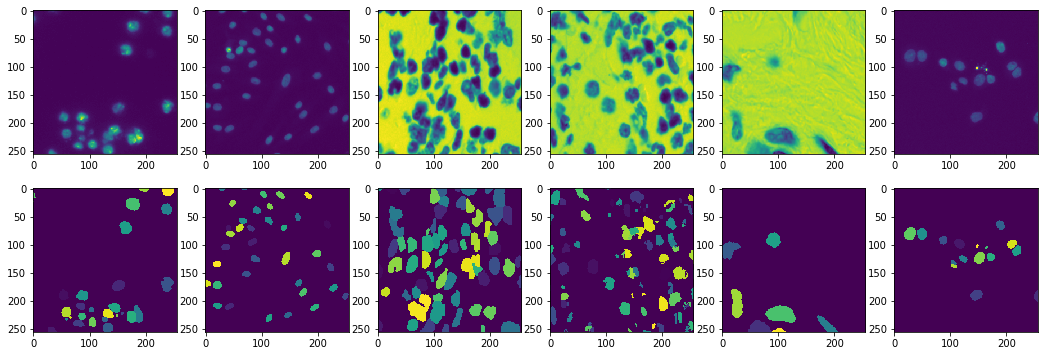

In [8]:
plt.rcParams['figure.figsize'] = [18, 6]

print(X.shape)

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(X[i]*std+mean)

    plt.subplot(2, 6, i+7)
    plt.imshow(Yeval[i])
#     print(Y[i][Y[i] == 1])
#     break
plt.show()

In [9]:
# split total training data
ix = np.random.choice(len(X), len(X), False)
tr, val = np.split(ix, [round(0.8*len(X))])

batch_size = 25

if useGray == True:
    X = X[:,:,:,np.newaxis]

print(X.shape)
print(Y.shape)

data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True) 
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])), 
                      batch_size=batch_size, shuffle=True)

data, label = next(iter(data_tr))
print(label.shape)

(670, 256, 256, 1)
(670, 256, 256)
torch.Size([25, 1, 256, 256])


## now, ready for sematic segmentation using DL

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
def bce_loss(y_real, y_pred):
#     return torch.mean(-y_real*y_pred+torch.log(1 + torch.exp(y_pred)))
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

def train(model, opt, loss_fn, epochs, data_tr, data_val,verbose=False):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print(' - loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = F.sigmoid(model(X_val.to(device))).detach().cpu()
        if verbose == False:
            clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            img = X_val[k].numpy()
            img = np.rollaxis(img,0,3)
            if img.shape[2] == 1:
                img = np.reshape(img,(img.shape[0],img.shape[1]))
            plt.imshow(img, cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [12]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))()) for X_batch, _ in data]
    return np.array(Y_pred)

In [13]:
class UNet2(nn.Module):
    def __init__(self, inChannels):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(inChannels, 64, 3, padding=1, stride=1) # 256
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1, stride=2) # 256->128
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1, stride=2) # 128->64
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1, stride=2) # 64->32

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1, stride=2) #32->16

        # decoder (upsampling)
        self.dec_deconv0 = nn.ConvTranspose2d(64,64, 2, stride=2)
        self.dec_conv0 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.dec_deconv1 = nn.ConvTranspose2d(64,64, 2, stride=2)
        self.dec_conv1 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.dec_deconv2 = nn.ConvTranspose2d(64,64,kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.dec_deconv3 = nn.ConvTranspose2d(64,64,kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv2d(64*2, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        conv0 = F.relu(self.enc_conv0(x)) ## save this, concatenate later
        conv1 = F.relu(self.enc_conv1(conv0))
        conv2 = F.relu(self.enc_conv2(conv1))
        conv3 = F.relu(self.enc_conv3(conv2))

        # bottleneck
        b = F.relu(self.bottleneck_conv(conv3))

        # decoder
        up0 = self.dec_deconv0(b)
        up0concate = torch.cat((up0,conv3),1)
        d0 = F.relu(self.dec_conv0(up0concate))
        
        up1 = self.dec_deconv1(d0)
        up1concate = torch.cat([up1,conv2],1)
        d1 = F.relu(self.dec_conv1(up1concate))
        
        up2 = self.dec_deconv2(d1)
        up2concate = torch.cat([up2,conv1],1)
        d2 = F.relu(self.dec_conv2(up2concate))
                    
        up3 = self.dec_deconv3(d2)
        up3concate = torch.cat([up3,conv0],1)
        d3 = self.dec_conv3(up3concate)  # no activation
        
        return d3



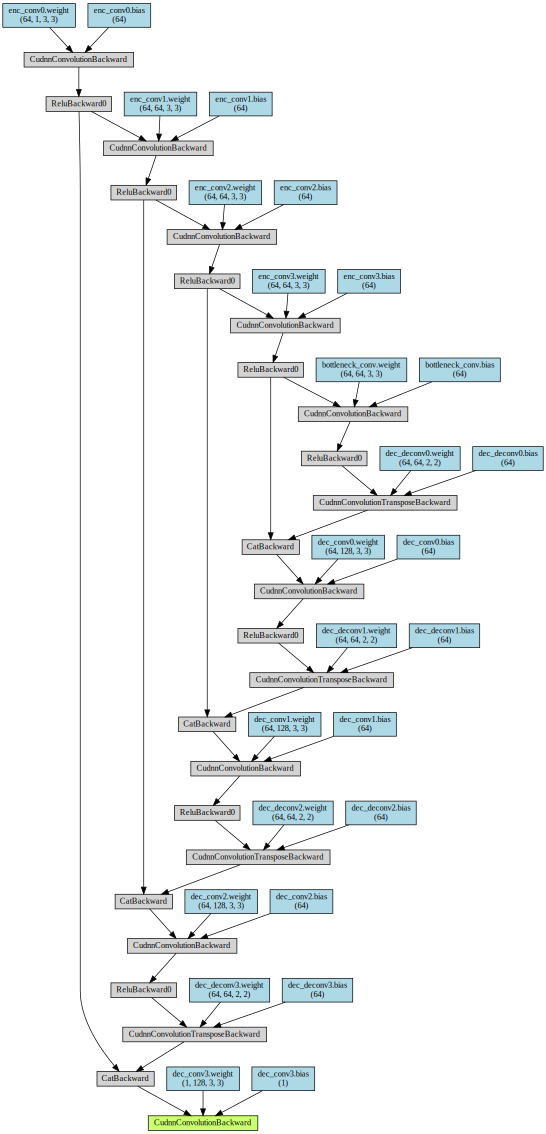

In [14]:
inChannels = 3 if useGray == False else 1
model = UNet2(inChannels).to(device)
make_dot(model(torch.randn(20, inChannels, 256, 256).cuda()), params=dict(model.named_parameters()))


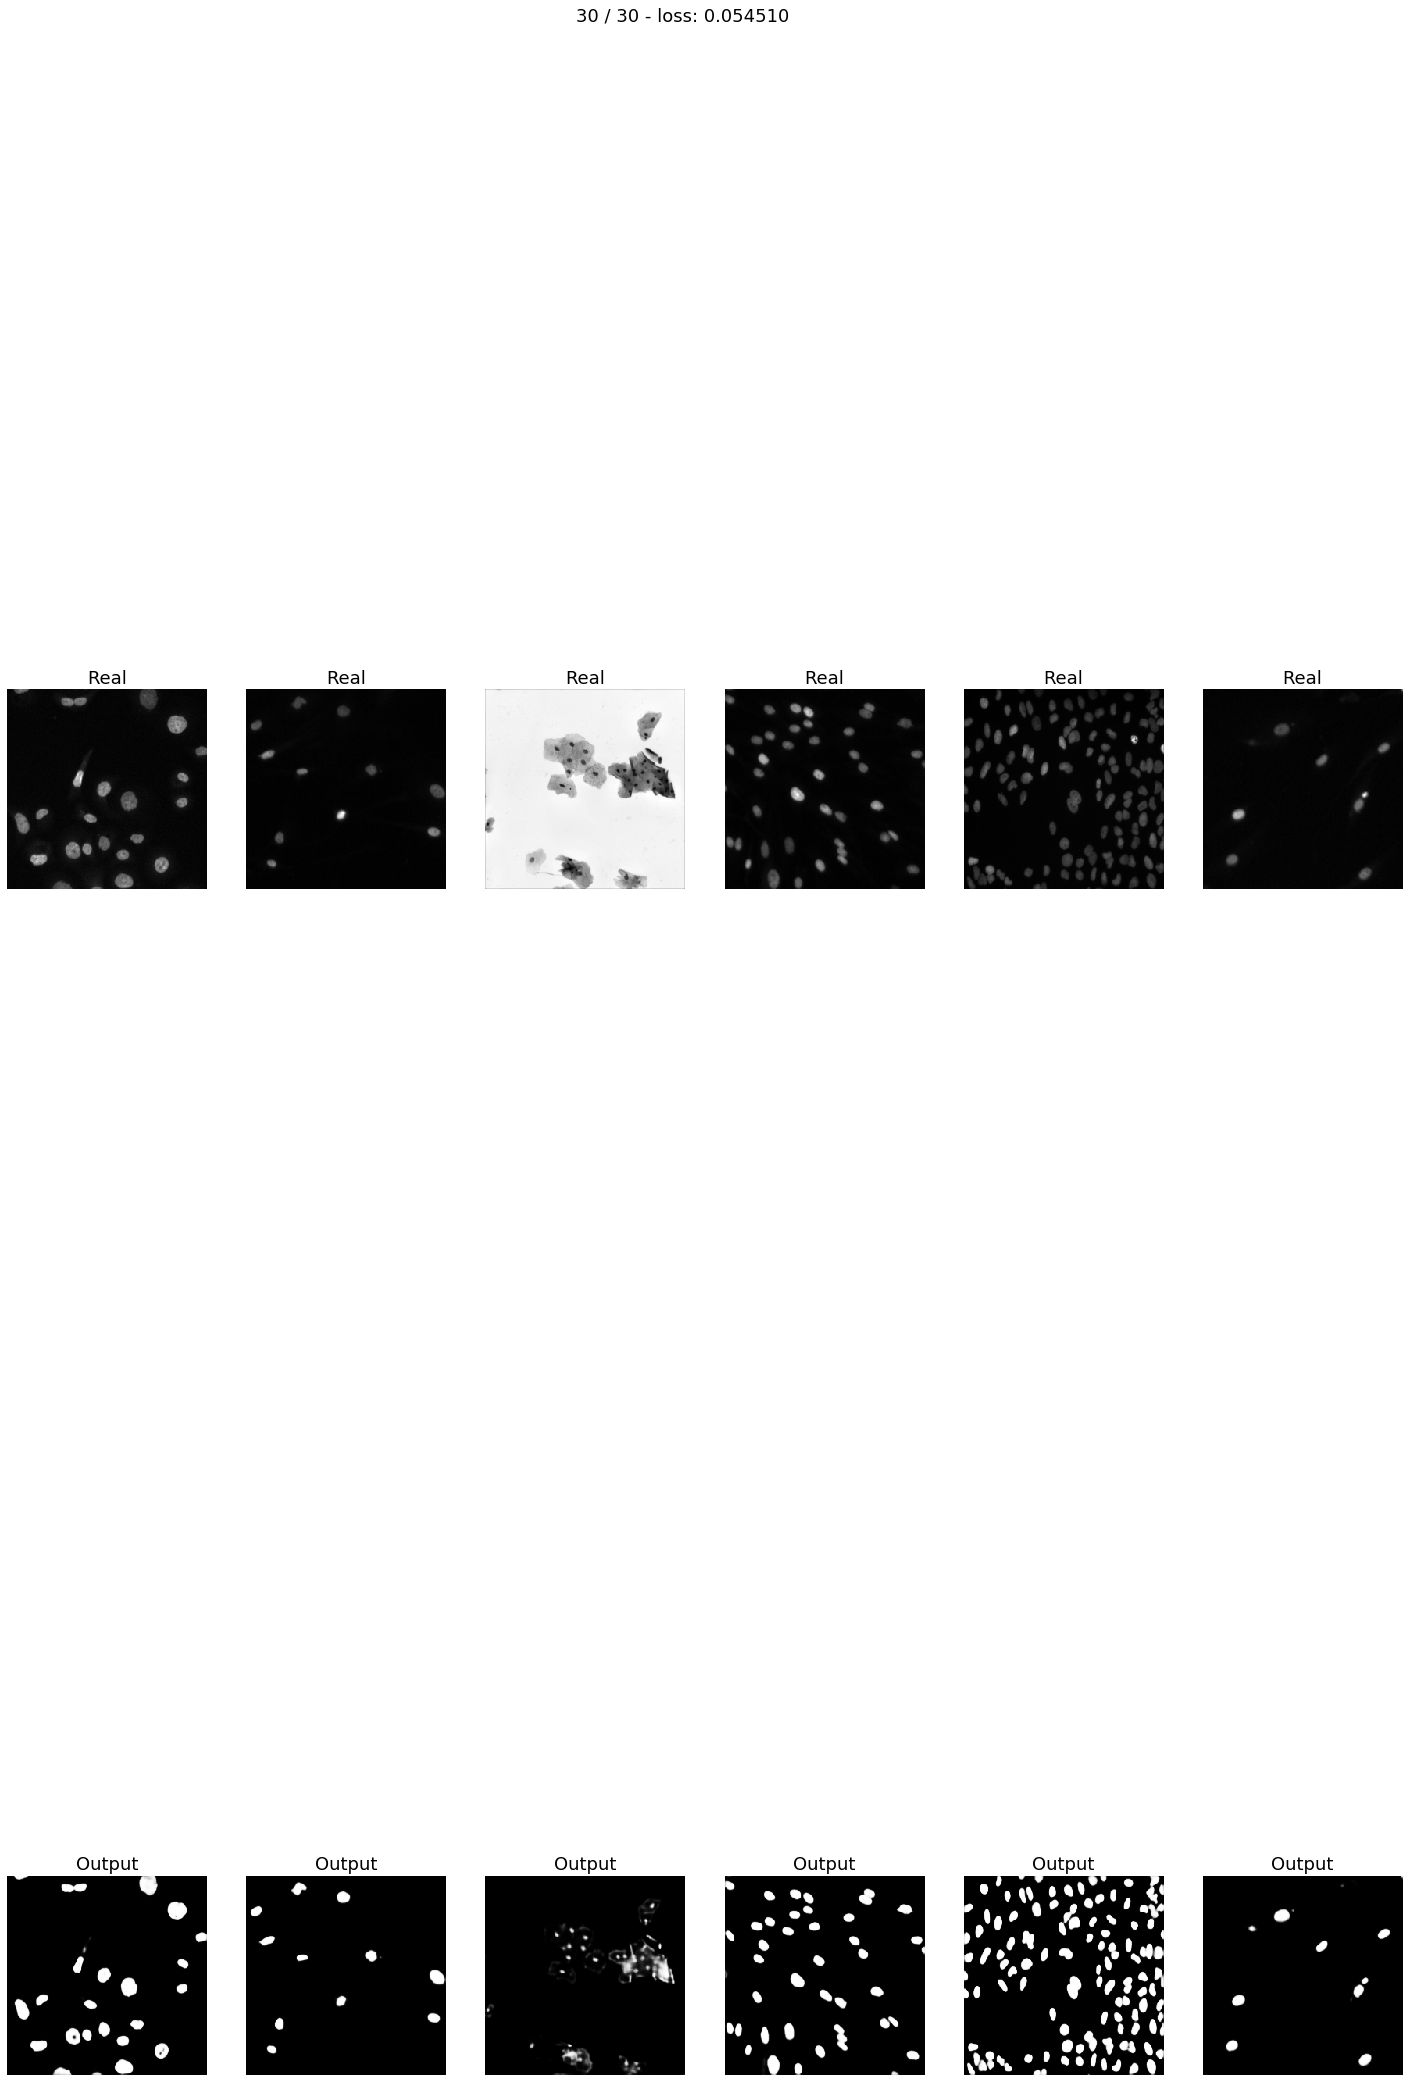

In [36]:
train(model, optim.Adam(model.parameters(), 1e-3), bce_loss, 30, data_tr, data_val)

## Compute IoU

In [37]:
# run with final model
SegPred = []
SegTrue = []


# cancel shuffle
data_val_ordered = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])), 
                              batch_size=batch_size, shuffle=False)

print(X.shape)

model.eval()  # testing mode

for data, label in data_val_ordered:
    Y_hat = torch.sigmoid(model(data.to(device))).detach().cpu()
    SegPred.append(Y_hat.numpy())
    SegTrue.append(label.numpy())

(670, 256, 256, 1)


In [57]:
def IoU(truth, pred):
    mask_int = truth & pred
    mask_union = truth | pred
    area_int = mask_int.sum()
    area_union = mask_union.sum()
#     print('%s, %s'%(area_int,area_union))
    return area_int / area_union

def evaluation(truth, pred, verbose = False, iou_threshold = 0.5):
    ## suppose pred has been watershed or labeled
    number_of_objects = np.unique(truth) ## remove background
    #print("iou_threshold:%s"%iou_threshold)
    
    TP = 0
    FP = 0
    FN = 0
    
    for i in range(len(number_of_objects)-1):
        current_label = number_of_objects[i + 1]
        mask_truth = truth  == current_label
        mask_intersect = pred[mask_truth]
        if not np.any(mask_intersect):
            FN+=1
            continue
        pred_labels, counts = np.unique(mask_intersect, return_counts = True)
        idx = np.argmax(counts)
        matched_label = pred_labels[idx]
        mask_pred = pred == matched_label
        iou = IoU(mask_truth, mask_pred)
        if verbose == True:
            print(pred_labels)
            print(iou)
        if iou >= iou_threshold:
            # correct
            TP+=1
            # mask out pred
            pred[mask_pred] = 0
    FP = len(np.unique(pred)) - 1
    precision = TP / (TP+FP+FN)
    return precision, TP, FP, FN
        

(25, 1, 256, 256)
iou_threshold:0.5
precision 0.8, TP 8, FP 1, FN 1
iou_threshold:0.5
precision 0.8888888888888888, TP 8, FP 1, FN 0
iou_threshold:0.5
precision 0.8360655737704918, TP 102, FP 10, FN 10
iou_threshold:0.5
precision 0.32, TP 8, FP 17, FN 0
iou_threshold:0.5
precision 0.7866666666666666, TP 59, FP 13, FN 3
iou_threshold:0.5
precision 0.9010989010989011, TP 82, FP 5, FN 4
iou_threshold:0.5
precision 0.9137931034482759, TP 106, FP 6, FN 4
iou_threshold:0.5
precision 0.9545454545454546, TP 21, FP 1, FN 0
iou_threshold:0.5
precision 0.8648648648648649, TP 32, FP 5, FN 0
iou_threshold:0.5
precision 0.16535433070866143, TP 21, FP 66, FN 40
iou_threshold:0.5
precision 0.68, TP 34, FP 14, FN 2
iou_threshold:0.5
precision 0.16666666666666666, TP 1, FP 5, FN 0
iou_threshold:0.5
precision 0.9166666666666666, TP 22, FP 2, FN 0
iou_threshold:0.5
precision 0.9090909090909091, TP 20, FP 0, FN 2
iou_threshold:0.5
precision 0.5, TP 3, FP 2, FN 1
iou_threshold:0.5
precision 0.83333333333333

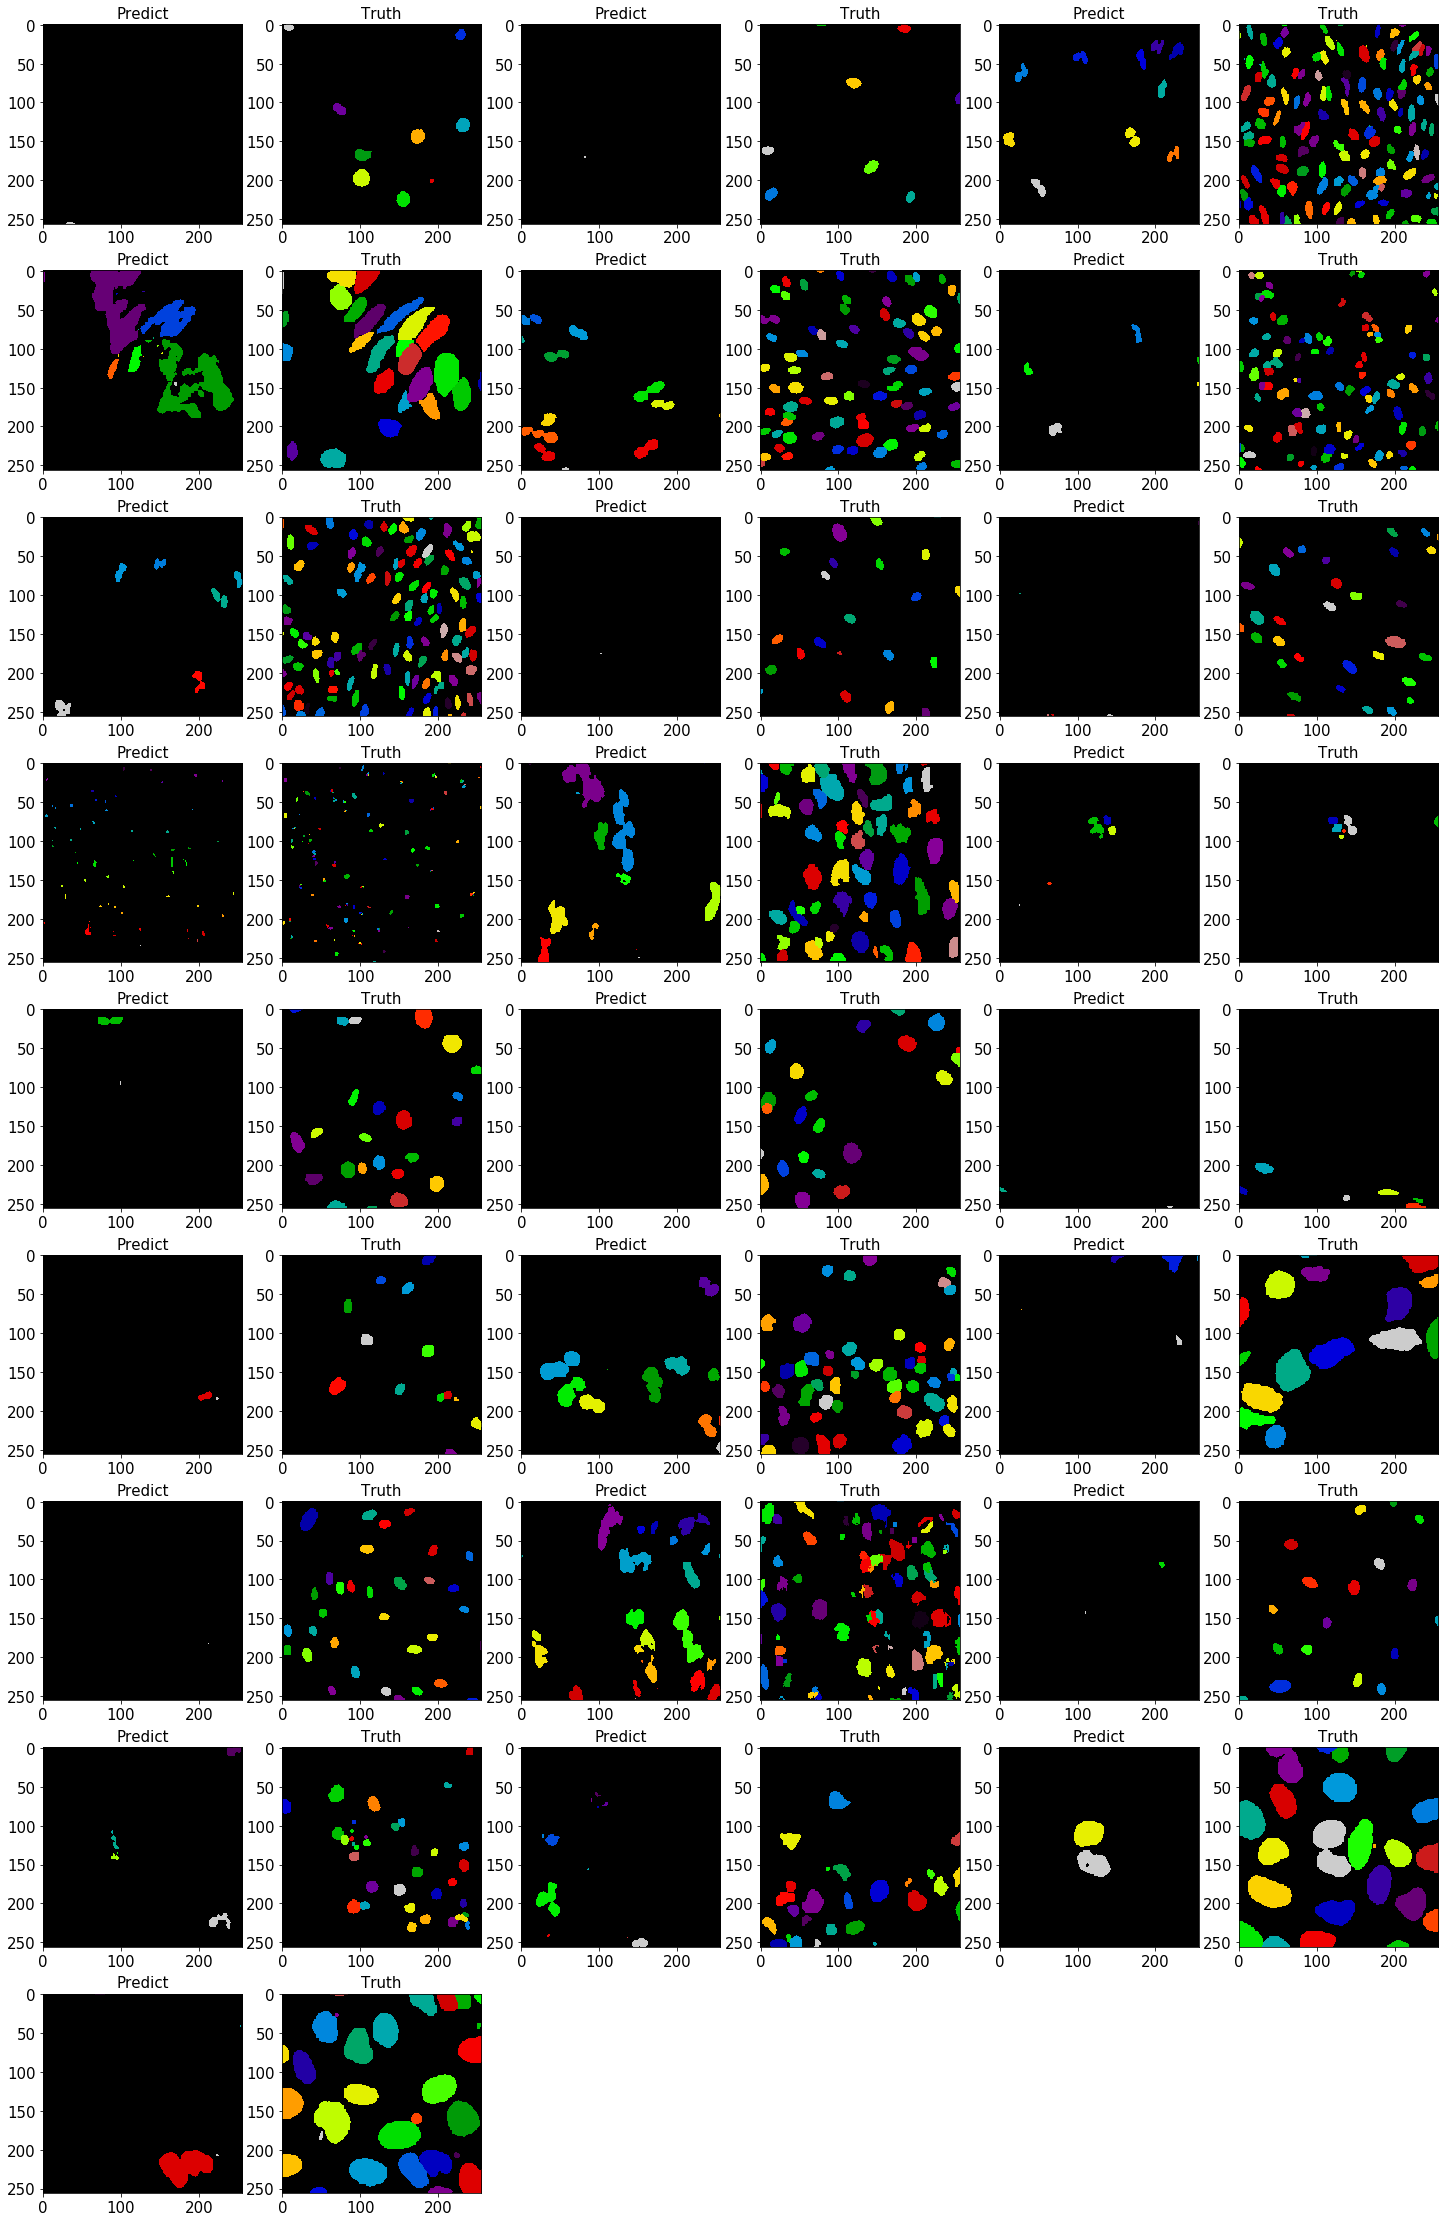

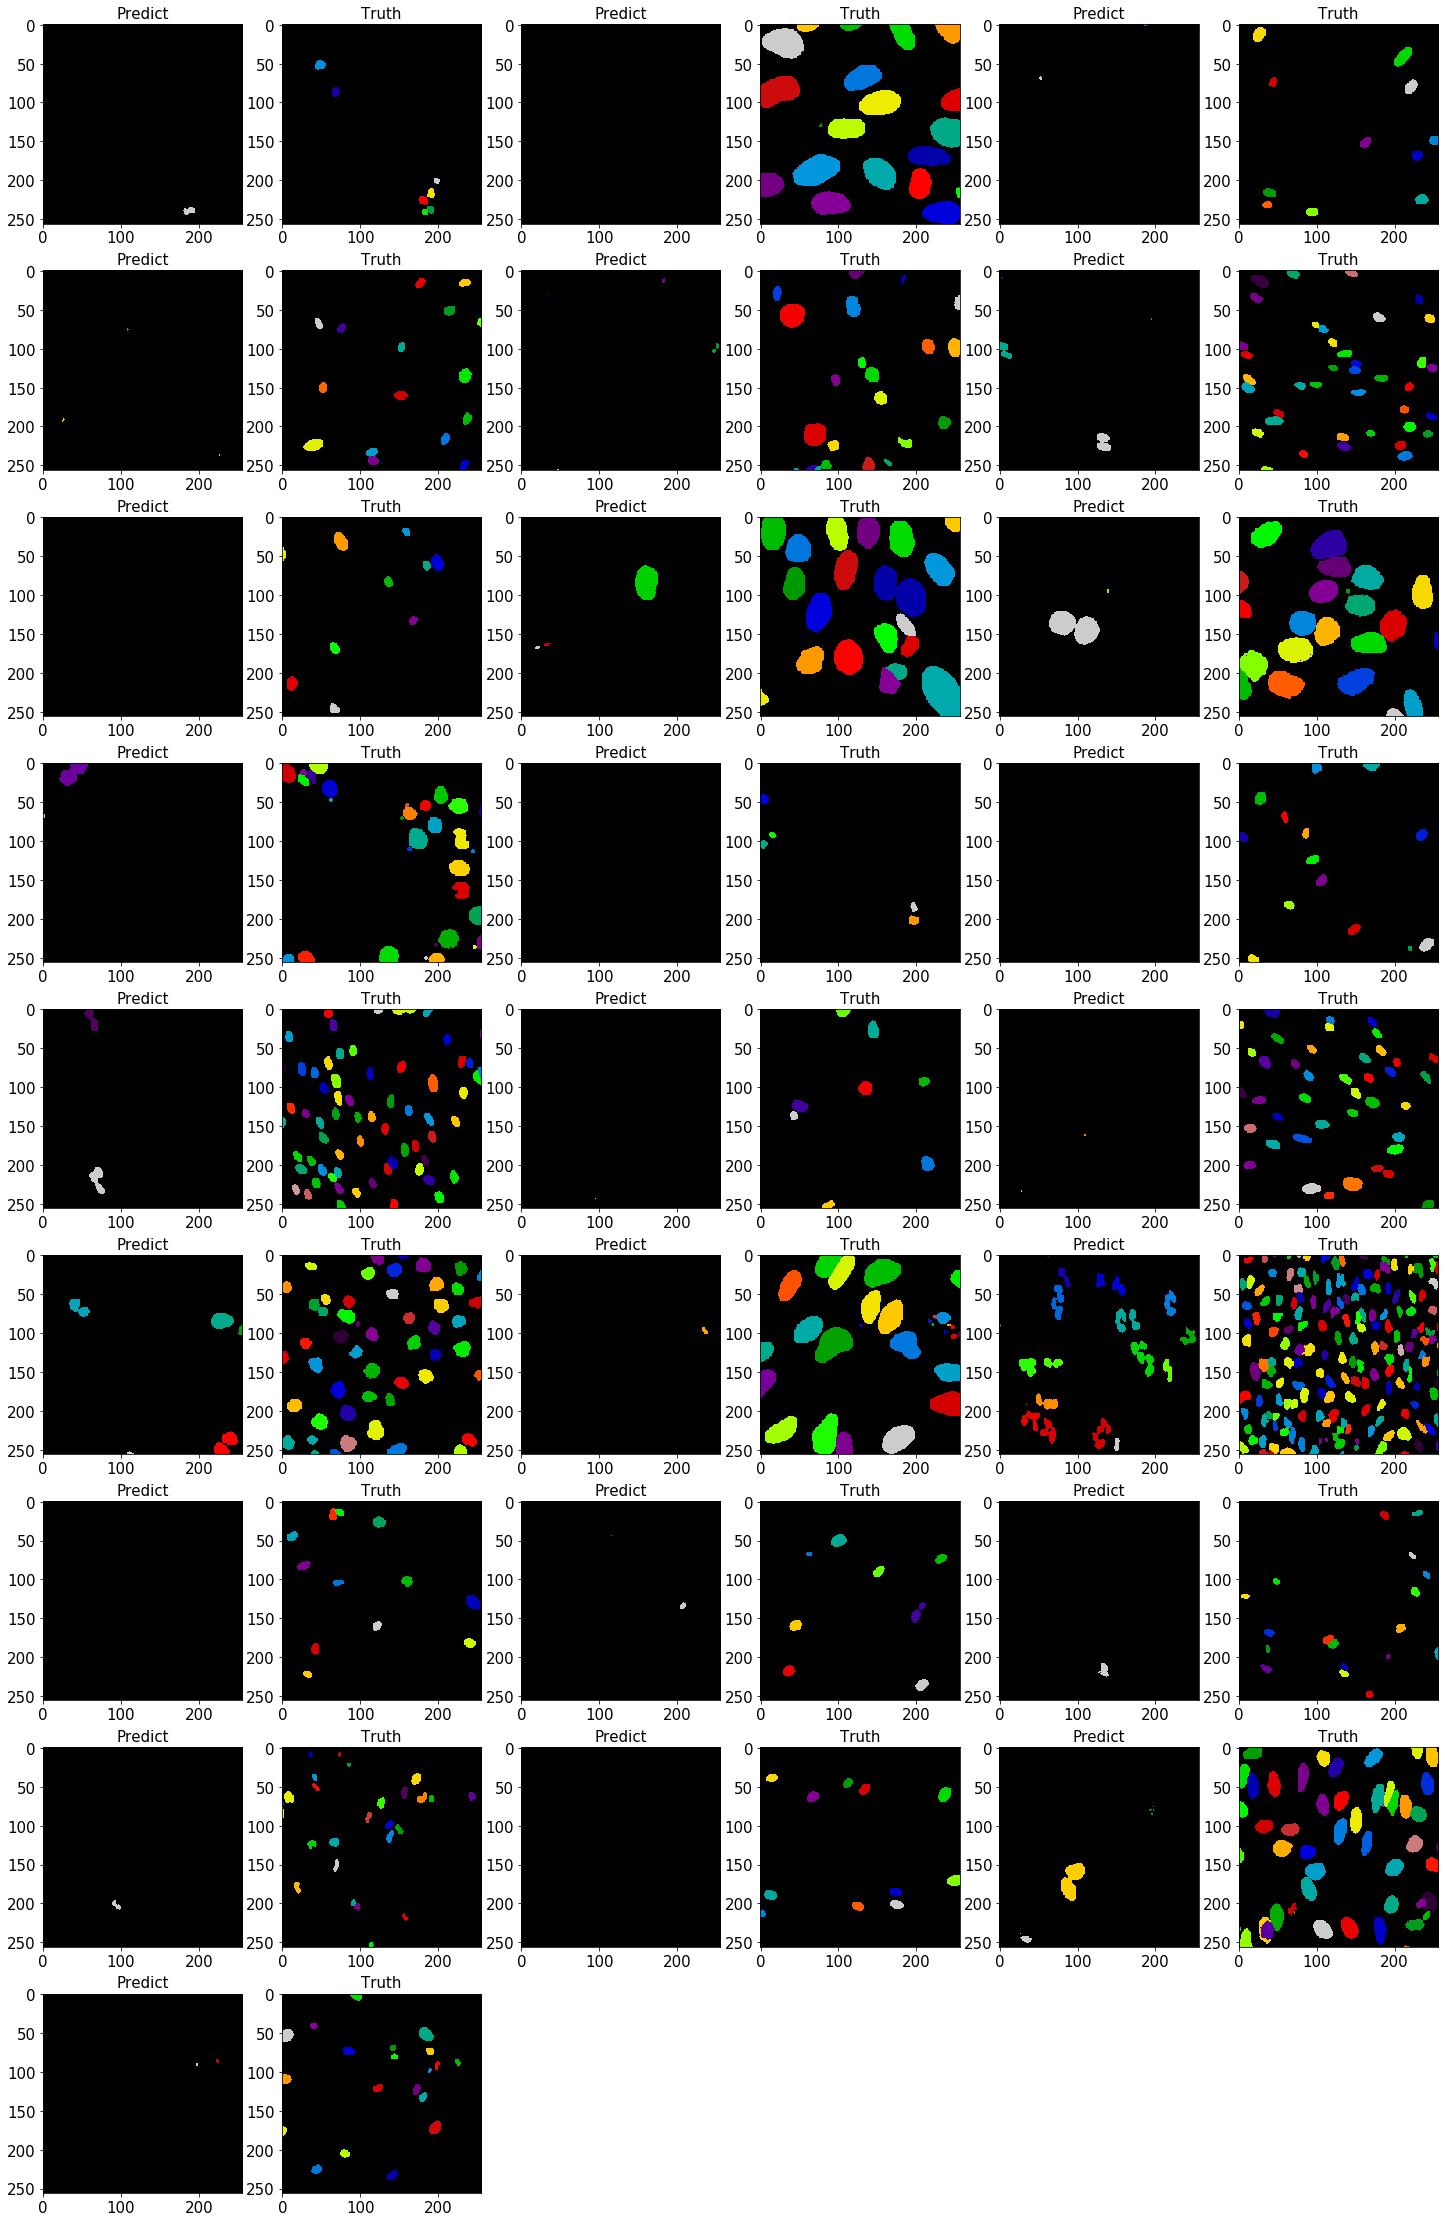

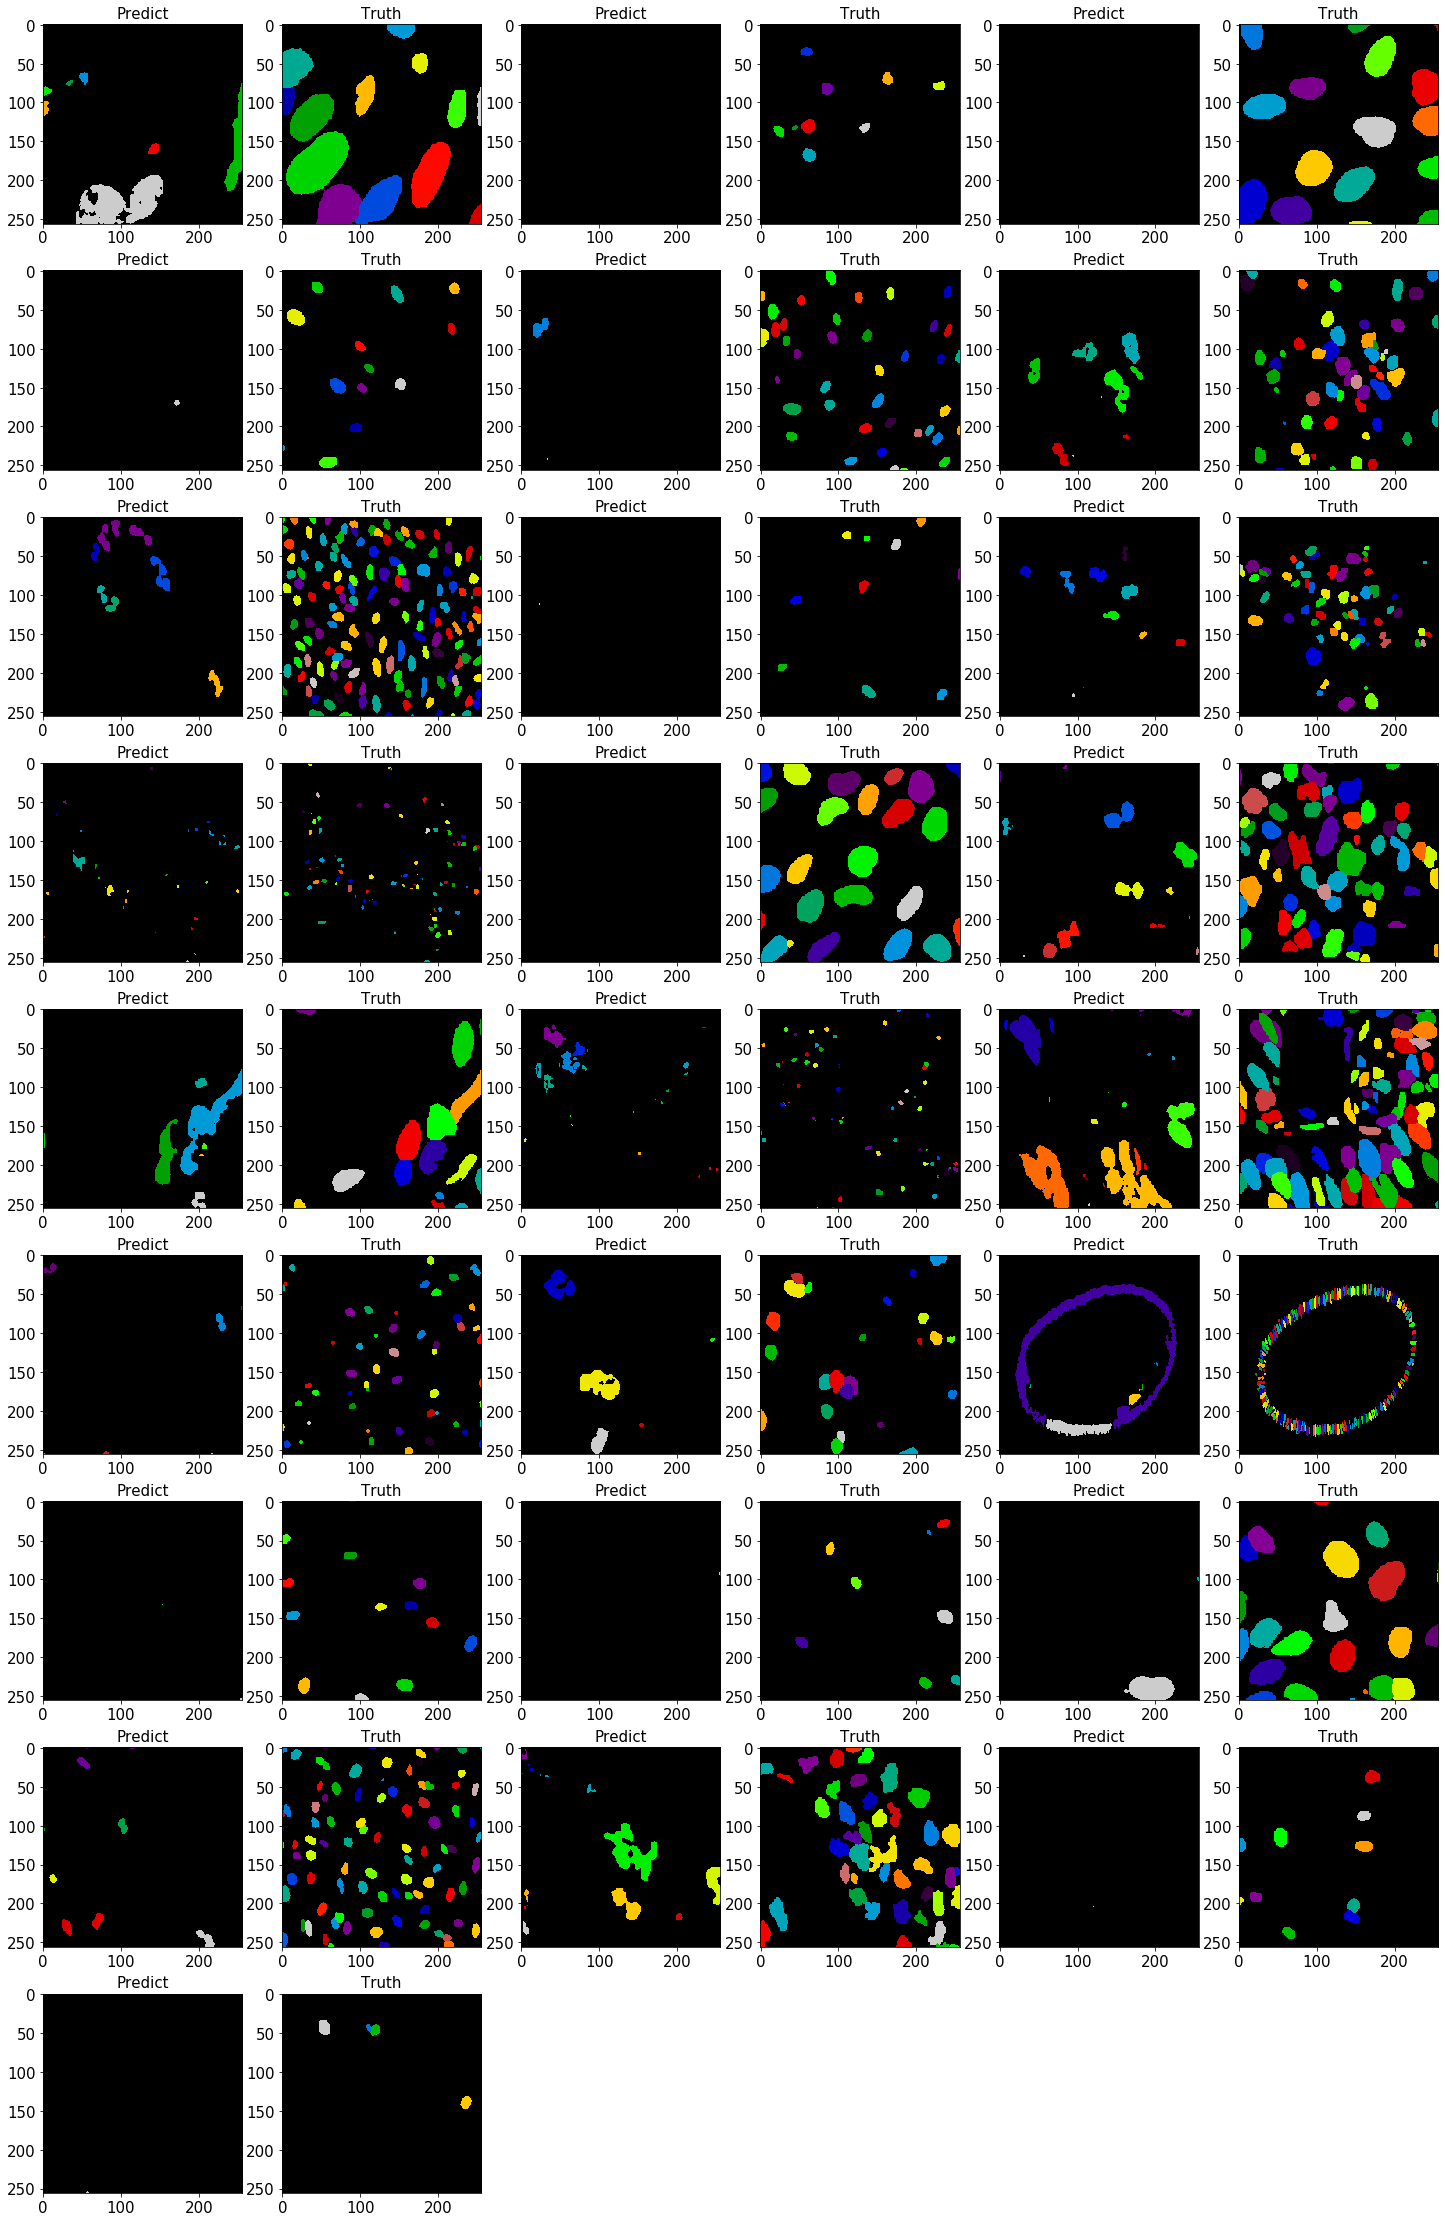

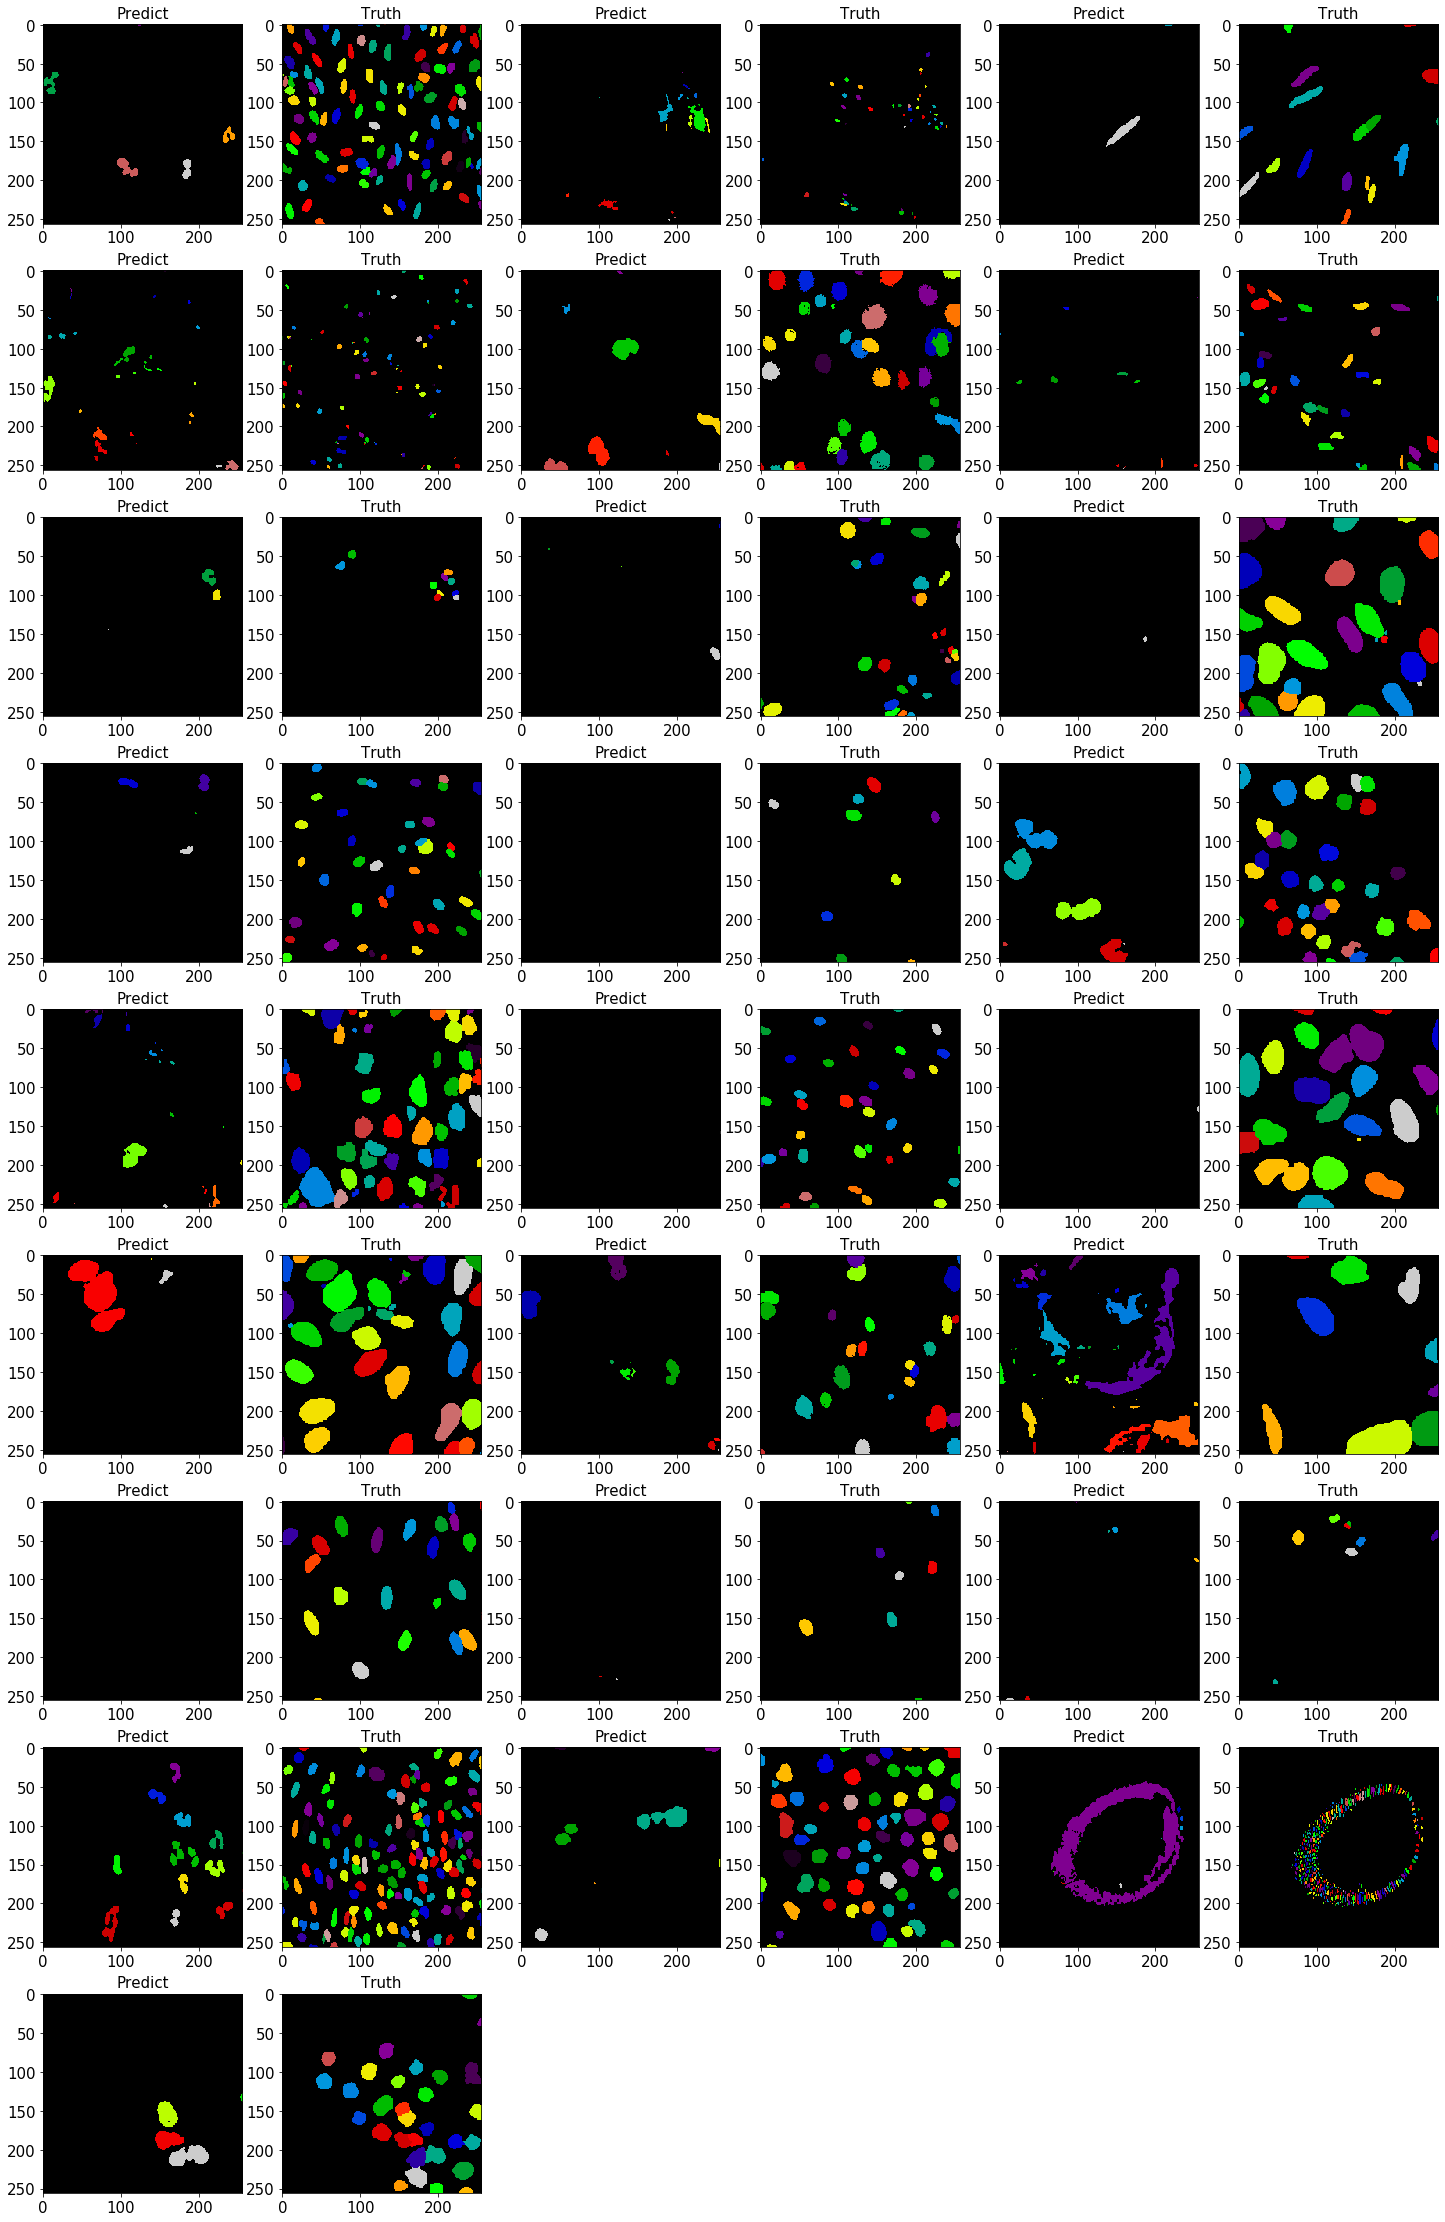

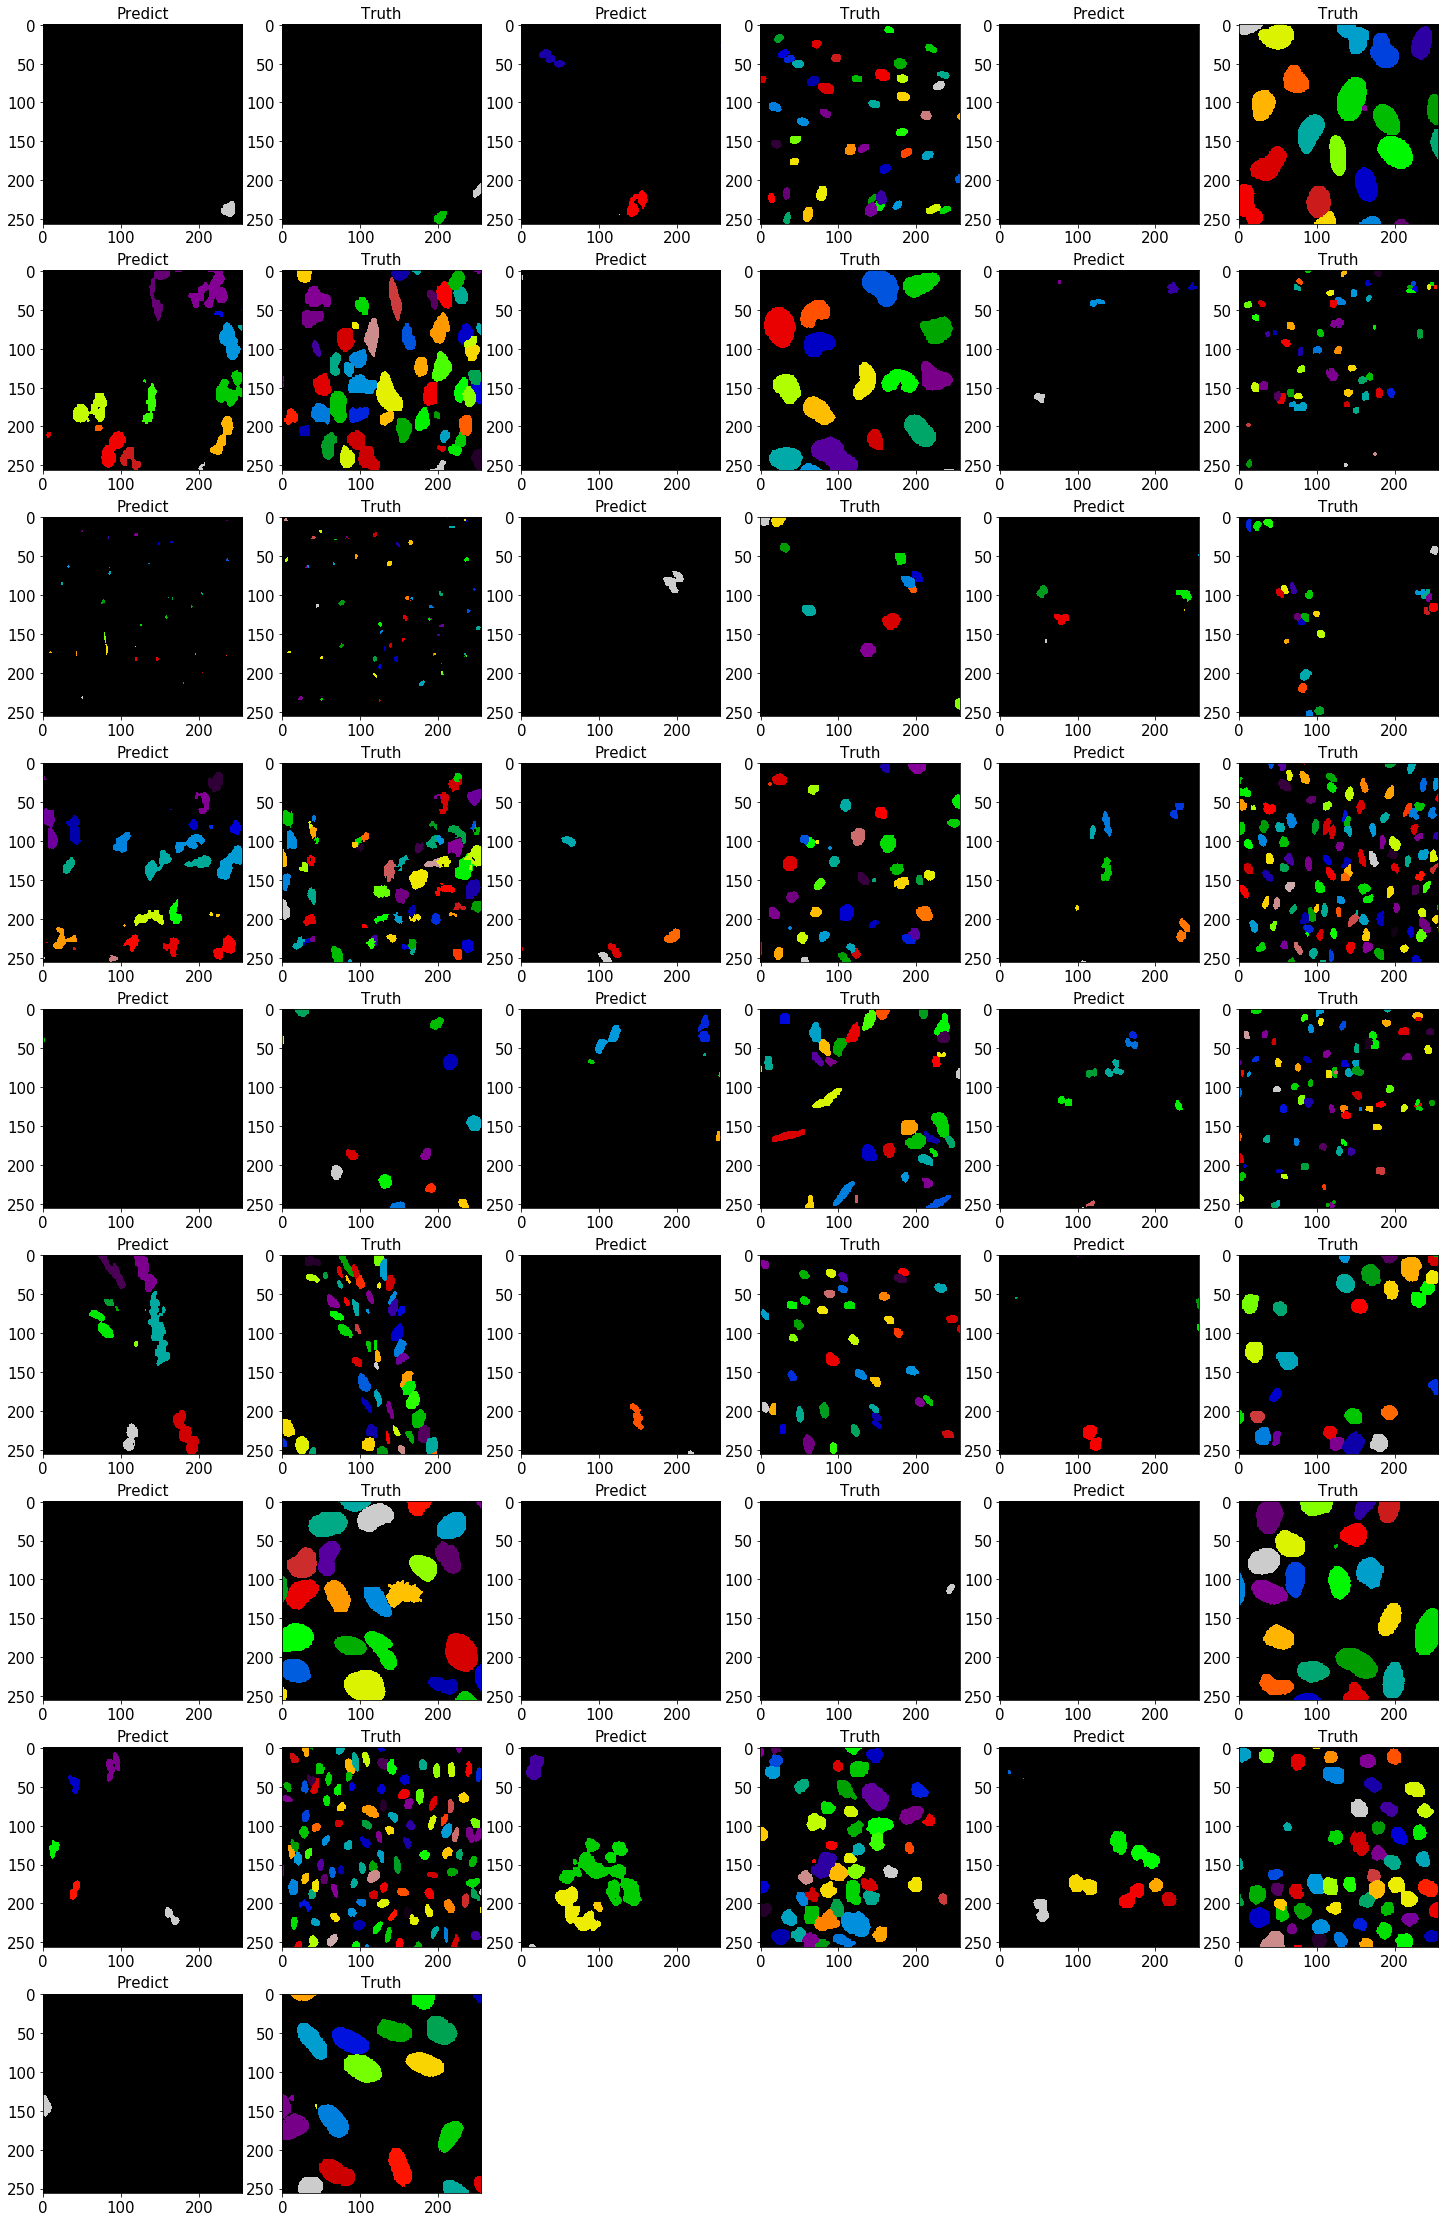

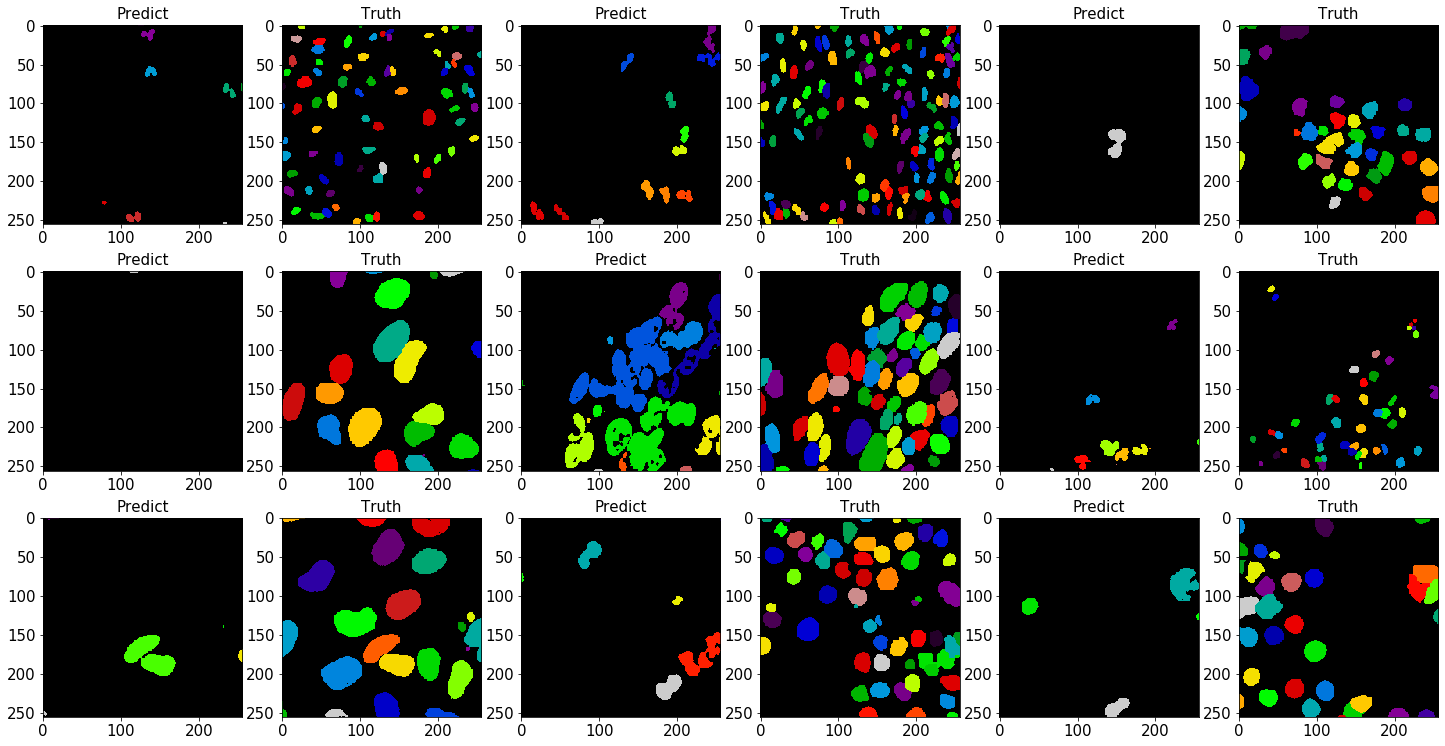

In [50]:
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage import img_as_int, img_as_float
import scipy.ndimage as ndi #import label, generate_binary_structure
from skimage.feature import peak_local_max
from skimage.morphology import watershed, disk
from skimage.filters import rank


def tensor_to_grayimg(ts):
    img = img_as_float(ts)
    img = np.rollaxis(img,0,3)
    img = np.reshape(img,(img.shape[0],img.shape[1]))
    return img

plt.rcParams['figure.figsize'] = [25, 40]
plt.rc('font', size=15)          # controls default text sizes

# show final results
i = 0
for batch_img, batch_label in zip(SegPred, SegTrue):
    print(batch_label.shape)
    plt.figure()
    for j in range(batch_img.shape[0]):
        img = tensor_to_grayimg(batch_img[j,:,:,:])
        im_label = tensor_to_grayimg(batch_label[j,:,:,:])
        img[img <= 0.5] = 0
#         img[img > 0.5] = 1
        markers = np.zeros_like(img,np.int)
        markers[img < 0.5] = 1
        markers[img >= 0.5] = 2
        # process the watershed
        label_image = watershed(img, markers)
        # label image regions
#         label_image = ndi.binary_fill_holes(label_image-1)
        label_image_c, numbers = ndi.label(label_image-1)
#         print(np.unique(label_image_c))
        precision, TP, FP, FN = evaluation(Yeval[val[i]].copy(), label_image_c)
        
        print("precision %s, TP %s, FP %s, FN %s"%(precision, TP, FP, FN))
        
#         precision, TP, FP, FN = evaluation(Yeval[val[i]].copy(), label_image_c, True)
        
#         # dempster distance
#         distance = ndi.distance_transform_edt(img)
#         local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
#                                     labels=img)
#         markers = ndi.label(local_maxi)[0]
#         label_image = watershed(-distance, markers, mask=img)
        
        
#         print(numbers)
#         label_image_c = label2rgb(label_image)

        plt.subplot(9, 6, j*2+1)
        plt.imshow(label_image_c,cmap=plt.cm.nipy_spectral,)
        plt.title('Predict',fontsize='medium')
        plt.subplot(9, 6, j*2+2)
        plt.imshow(Yeval[val[i]],cmap=plt.cm.nipy_spectral,)
        plt.title('Truth',fontsize='medium')
        i+=1

In [55]:
def evaluate_all(true, pred, t):
    precisions = []
    i = 0
    for batch_img in pred:
        for j in range(batch_img.shape[0]):
            img = tensor_to_grayimg(batch_img[j,:,:,:])
            img[img <= 0.5] = 0
#         img[img > 0.5] = 1
            markers = np.zeros_like(img,np.int)
            markers[img < 0.5] = 1
            markers[img >= 0.5] = 2
            # process the watershed
            label_image = watershed(img, markers)
            # label image regions
            label_image_c, numbers = ndi.label(label_image-1)
            precision, _, _, _ = evaluation(true[val[i]].copy(), label_image_c.copy(), 
                                            iou_threshold=t)
            precisions.append(precision)
            i+=1
    return precisions

In [ ]:
## iterate with iou threshold and plot curve
ts = np.arange(0.5,0.8,0.05,np.float32)
mean_precision = np.zeros_like(ts, np.float32)
k = 0
for t in tqdm(ts):
    print(t)
    precisions_of_current_threshold = evaluate_all(Yeval, SegPred, t)
    precisions_of_current_threshold = np.array(precisions_of_current_threshold,np.float32)
    print(precisions_of_current_threshold.mean(axis=0))
    mean_precision[k] = precisions_of_current_threshold.mean()
    k+=1

0.5
0.7608505
0.55
0.74098456
0.6
0.71740985
0.65000004


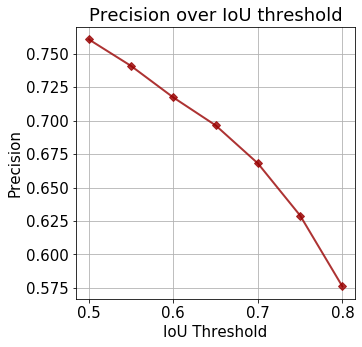

In [68]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.figure()
plt.plot(ts, mean_precision,'-D',c='#990000',alpha=0.8,linewidth=2,label='mean precision')
plt.title('Precision over IoU threshold')
plt.xlabel('IoU Threshold')
plt.ylabel('Precision')
plt.grid(True)
# plt.savefig('xxxx.png',dpi=300)

## todo:
1. use watershad for region detection: **done**
2. compute IoU and evaluation score: **done**
3. input preprocessing:
    * data augmentation/network design/training: wu/zhao
    * erosion / dilation: huxiao
    * loss function + weights: dempster-shafer distance: huxiao
    * load, find contour, + class, background, foreground, border: huxiao

## Questions: 
1. evaluation on resized image or on raw mask image?
    1.1. if on raw image: the raw masks are separate, i.e. each pixel belongs to 1 mask. (however, if use component connected algorithm on the combined mask image, objects may be treated as 1)
    1.2  if on the resize combined mask, because of downsampling, the resized combined mask will be connected more probably.
    
2. ~~about find true positive, false posititve, false negative: use once or more? **if one predicted hits, should we make a flag and for later identification, we never use predicts that has been marked with a flag?** if not use flag, is it fair?~~

Answer from Kaggle: 
> The metric checks that the pairs are sorted, positive, and **the decoded pixel values are not duplicated**. It also checks that **no two predicted masks for the same image are overlapping**.

> https://www.kaggle.com/c/data-science-bowl-2018/discussion/47864#latest-314862

After viewing the submission csv files:
1. instance segmentation: each predicted object can only be used once;
2. use run-length encoding for competition:
    2.1 for one image, if there are multiple nucleus, then just generate multiple lines of run-length encoding. see **stage1_train_labels.csv** as an example.
3. stage1_solution.csv is the labels for stage1_test images.
4. stage2_solution_final.csv is the labels for stage2_test images.




very challenging:
> Left is contrast enhanced image # 'f8e74d4006dd68c1dbe68df7be905835e00d8ba4916f3b18884509a15fdc0b55' Right is the image labeled using the mask from the training set. Are these small objects really nuclei? bad annotation? ![raw_image](https://i.imgur.com/X7rdSRC.png)

another example:
masks with holes, masks with noise (single pixel nuclei)
![sample_image0](
https://www.kaggle.io/svf/2357892/9ec4f3ca4132c19296b2c63ed7f924df/__results___files/__results___4_0.png)
![sample_image1](
https://www.kaggle.io/svf/2357892/9ec4f3ca4132c19296b2c63ed7f924df/__results___files/__results___6_0.png)
![sample_image2](https://www.kaggle.io/svf/2359003/4a7901ca80e0619a44a2995a431e4e3b/__results___files/__results___8_0.png)

In [52]:
d=np.array([1, 1, 2, 2, 3, 3])
a,b,c = np.unique(d,return_inverse=True,return_counts=True)
print(a)
print(b)
print(c)
print(a[b])
b = np.zeros([3,2])
all_zeros = not np.any(b)
print(all_zeros)

[1 2 3]
[0 0 1 1 2 2]
[2 2 2]
[1 1 2 2 3 3]
True


In [27]:
ts = np.arange(0.5,0.8,0.05,np.float32)
print(ts)

[0.5        0.55       0.6        0.65000004 0.70000005 0.75000006
 0.8000001 ]
